In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
from grepfunc import grep
import os,sys
from Bio import SeqIO

## Input drugbank file

In [2]:
data = pd.read_csv("process_drug_uniprot_link_update.txt", sep="\t", index_col=False)
print(data.count())

data1 = pd.read_csv("processed_drugs_name_uniq_March2020.txt", sep="\t")
data1.head()

Drugbank_ids    20744
Uniprot_ids     20744
dtype: int64


,Drugbank_ids,Drugs_name,Drug_type
0,DB00001,Lepirudin,BiotechDrug
1,DB00002,Cetuximab,BiotechDrug
2,DB00004,Denileukin diftitox,BiotechDrug
3,DB00005,Etanercept,BiotechDrug
4,DB00006,Bivalirudin,SmallMoleculeDrug


## Input individual virus file

In [3]:
input_expt_p = pd.read_csv("Done_6639/Rift/updated/pos.txt", sep="\t", index_col=False)
input_expt_p=input_expt_p.drop_duplicates(subset='DrugBank_ids', keep='first', inplace=False)
input_expt_ps=input_expt_p.dropna(subset=['Uniprot_id'])
input_expt_pos=input_expt_ps[['DrugBank_ids','Uniprot_id']]
print(input_expt_pos.count())
print(input_expt_pos)

input_expt_n = pd.read_csv("Done_6639/Rift/updated/neg.txt", sep="\t", index_col=False)
input_expt_n=input_expt_n.drop_duplicates(subset='DrugBank_ids', keep='first', inplace=False)
input_expt_ng=input_expt_n.dropna(subset=['Uniprot_id'])
input_expt_neg=input_expt_ng[['DrugBank_ids','Uniprot_id']]
print(input_expt_neg.count())
print(input_expt_pos.head())




DrugBank_ids    2
Uniprot_id      2
dtype: int64
  DrugBank_ids                                         Uniprot_id
0      DB00398  P35916; P04049; P35968; P15056; P36888; P09619...
2      DB00877                             P42345; P62942; P09038
DrugBank_ids    3
Uniprot_id      3
dtype: int64
  DrugBank_ids                                         Uniprot_id
0      DB00398  P35916; P04049; P35968; P15056; P36888; P09619...
2      DB00877                             P42345; P62942; P09038


## Layer 1 (Positive)

In [4]:
## Input Target ids and extract unique target ids

target_ids = input_expt_pos['Uniprot_id']
join_line= (','.join(line for line in target_ids))
join_line=join_line.replace('; ',',')
join_line=join_line.split(',')
l2df = pd.DataFrame(join_line)

expt0_uniq=l2df.drop_duplicates(keep='first', inplace=False)
print(type(join_line))
print(l2df.count())
print(expt0_uniq.count())
expt0_uniq.head()

#expt0_uniq.to_csv("try_target_ncov.txt")

<class 'list'>
0    13
dtype: int64
0    13
dtype: int64


,0
0,P35916
1,P04049
2,P35968
3,P15056
4,P36888


In [5]:
## Map unique target ids -> Drugs on Drugbank file

data_merge = pd.merge(expt0_uniq, data, left_on=0, right_on='Uniprot_ids', how = 'inner')
#data_merge[['Drugbank_ids', 'Uniprot_ids']].head()
data_merge_uniq=data_merge['Drugbank_ids'].drop_duplicates(keep='first', inplace=False)
print(data_merge.count())
print(data_merge_uniq.count())
data_merge.head()

data_merge.head()

0               194
Drugbank_ids    194
Uniprot_ids     194
dtype: int64
103


,0,Drugbank_ids,Uniprot_ids
0,P35916,DB00398,P35916
1,P35916,DB01268,P35916
2,P35916,DB04879,P35916
3,P35916,DB05075,P35916
4,P35916,DB05932,P35916


In [6]:
## Check frequency of mapped Drugs 
#grouped = data_merge.groupby('Drugbank_ids',sort=None).size()
grouped = data_merge.groupby(['Drugbank_ids']).Drugbank_ids.agg('count').to_frame('freq').reset_index()
print(grouped.count())
print (type(grouped))
grouped_sort_uniq=grouped.sort_values(by=['freq'], ascending=False)
grouped_sort_uniq.head()

grouped_sort_uniq.to_csv("try_ncov.txt")

Drugbank_ids    103
freq            103
dtype: int64
<class 'pandas.core.frame.DataFrame'>


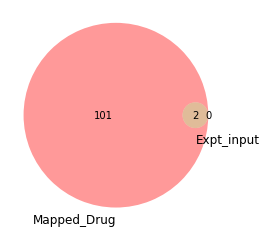

In [7]:
## Visualization of venn plot of Mapped Drugs and Expt anto-viral drugs

data_merge_drug=set(grouped_sort_uniq['Drugbank_ids'])
data_expt_drug=set(input_expt_pos['DrugBank_ids'])
venn2([data_merge_drug,data_expt_drug],['Mapped_Drug', 'Expt_input'])
#print(grouped_sort_uniq['Drugbank_ids'])

In [8]:
## Extract uniq mapped drugs which are not in input Expt anto-viral drugs

data_layer1_uniq=data_merge_drug.difference(data_expt_drug)
#print(data_layer1_uniq)
data_layer1_uniq1=list(data_layer1_uniq)
print(type(data_layer1_uniq1))

## Convert uniq mapped drugs to DataFrames

l2df2 = pd.DataFrame(data_layer1_uniq1, columns=["Drugs_id_layer1"])
print(type(l2df2))
l2df2.head()

<class 'list'>
<class 'pandas.core.frame.DataFrame'>


,Drugs_id_layer1
0,DB06595
1,DB05434
2,DB05932
3,DB05578
4,DB07840


In [9]:
## Extracting the top 20 drugs (excluding INPUT) as per the decreasing value of frequency

data_merge_order = pd.merge(l2df2, grouped_sort_uniq, left_on='Drugs_id_layer1', right_on='Drugbank_ids', how = 'inner')
print(data_merge_order.count())
print(data_merge_order.head())

grouped_sort_uniq_order=data_merge_order.sort_values(by=['freq'], ascending=False)
print(grouped_sort_uniq_order.head())

top_20=grouped_sort_uniq_order.nlargest(20,'freq')
top_20.head()

## extract the name of drugs

data_drugs_name = pd.merge(top_20, data1, left_on='Drugs_id_layer1', right_on='Drugbank_ids', how='inner')
data_drugs_name

Drugs_id_layer1    101
Drugbank_ids       101
freq               101
dtype: int64
  Drugs_id_layer1 Drugbank_ids  freq
0         DB06595      DB06595     4
1         DB05434      DB05434     1
2         DB05932      DB05932     2
3         DB05578      DB05578     1
4         DB07840      DB07840     1
   Drugs_id_layer1 Drugbank_ids  freq
7          DB12010      DB12010    11
43         DB08896      DB08896     9
66         DB01268      DB01268     6
10         DB09079      DB09079     6
15         DB09078      DB09078     6


,Drugs_id_layer1,Drugbank_ids_x,freq,Drugbank_ids_y,Drugs_name,Drug_type
0,DB12010,DB12010,11,DB12010,Fostamatinib,SmallMoleculeDrug
1,DB08896,DB08896,9,DB08896,Regorafenib,SmallMoleculeDrug
2,DB01268,DB01268,6,DB01268,Sunitinib,SmallMoleculeDrug
3,DB09079,DB09079,6,DB09079,Nintedanib,SmallMoleculeDrug
4,DB09078,DB09078,6,DB09078,Lenvatinib,SmallMoleculeDrug
5,DB06080,DB06080,5,DB06080,ABT-869,SmallMoleculeDrug
6,DB08901,DB08901,5,DB08901,Ponatinib,SmallMoleculeDrug
7,DB06589,DB06589,5,DB06589,Pazopanib,SmallMoleculeDrug
8,DB06595,DB06595,4,DB06595,Midostaurin,SmallMoleculeDrug
9,DB12147,DB12147,4,DB12147,Erdafitinib,SmallMoleculeDrug


## Layer 2 (Negative)

In [10]:
## Input Target ids and extract unique target ids

target_ids_neg = input_expt_neg['Uniprot_id']
join_line_neg= (','.join(line for line in target_ids_neg))
join_line_neg=join_line_neg.replace('; ',',')
join_line_neg=join_line_neg.split(',')
l2df_neg = pd.DataFrame(join_line_neg)

expt0_uniq_neg=l2df_neg.drop_duplicates(keep='first', inplace=False)
print(type(join_line_neg))
print(l2df_neg.count())
print(expt0_uniq_neg.count())
expt0_uniq_neg.head()

<class 'list'>
0    11
dtype: int64
0    11
dtype: int64


,0
0,Q02750
1,P41231
2,Q9NXA8
3,P23945
4,P21817


In [11]:
## Map unique target ids -> Drugs on Drugbank file

data_merge_neg = pd.merge(expt0_uniq_neg, data, left_on=0, right_on='Uniprot_ids', how = 'inner')
#data_merge[['Drugbank_ids', 'Uniprot_ids']].head()
data_merge_uniq_neg=data_merge_neg['Drugbank_ids'].drop_duplicates(keep='first', inplace=False)
print(data_merge_neg.count())
print(data_merge_uniq_neg.count())
data_merge_neg.head()


0               170
Drugbank_ids    170
Uniprot_ids     170
dtype: int64
162


,0,Drugbank_ids,Uniprot_ids
0,Q02750,DB02152,Q02750
1,Q02750,DB03115,Q02750
2,Q02750,DB05239,Q02750
3,Q02750,DB06616,Q02750
4,Q02750,DB06892,Q02750


In [12]:
## Check frequency of mapped Drugs 
#grouped = data_merge.groupby('Drugbank_ids',sort=None).size()
grouped_neg = data_merge_neg.groupby(['Drugbank_ids']).Drugbank_ids.agg('count').to_frame('freq').reset_index()
print(grouped_neg.count())
print (type(grouped_neg))
print(grouped_neg.sort_values(by=['freq'], ascending=False).head())

Drugbank_ids    162
freq            162
dtype: int64
<class 'pandas.core.frame.DataFrame'>
    Drugbank_ids  freq
54       DB04786     7
14       DB01103     3
0        DB00001     1
110      DB07376     1
104      DB07211     1


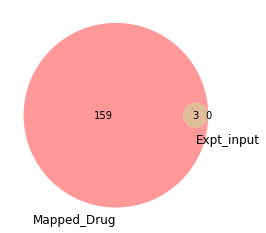

In [13]:
## Visualization of venn plot of Mapped Drugs and Expt anto-viral drugs

data_merge_drug_neg=set(data_merge_uniq_neg)
data_expt_drug_neg=set(input_expt_neg['DrugBank_ids'])
venn2([data_merge_drug_neg,data_expt_drug_neg],['Mapped_Drug', 'Expt_input'])

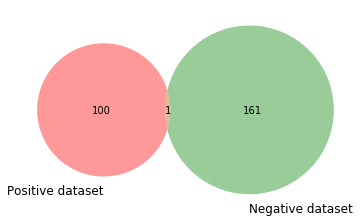

In [14]:
## Visualization of venn plot of Mapped Drugs and Expt anto-viral drugs

data_merge_drug_pos1=set(data_layer1_uniq1)  ### excluding INPUT drugs
data_map_drug_neg1=set(data_merge_uniq_neg)  #### including INPUT drugs
venn2([data_merge_drug_pos1,data_map_drug_neg1],['Positive dataset', 'Negative dataset'])

In [15]:
# data_merge_drug_pos1_common=data_map_drug_neg1.difference(data_layer1_uniq1)
df_pos=pd.DataFrame(data_layer1_uniq1)
df_neg=pd.DataFrame(data_merge_uniq_neg)
df_neg

data_merge10 = pd.merge(df_pos, df_neg, left_on=0, right_on='Drugbank_ids', how = 'inner')
# data_merge10.count()
data_merge10.to_csv("Done_6639/Rift/updated/Rift_common.txt", index=False)

### Visualization of venn plot of Mapped Drugs Targets and Expt anti-viral drug targets

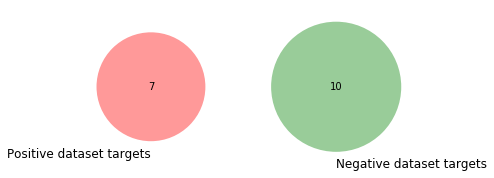

In [16]:
## Visualization of venn plot of Mapped Drugs Targets and Expt anto-viral drug targets

data_merge_drug_pos1_target=set(data_merge['Uniprot_ids'])  
data_map_drug_neg1_target=set(data_merge_neg['Uniprot_ids'])  
venn2([data_merge_drug_pos1_target,data_map_drug_neg1_target],['Positive dataset targets', 'Negative dataset targets'])


## Common target removed from positive datasets

In [47]:
## Get unique datasets in positive which are not in negative dataset

data_layer1_uniq_target=data_merge_drug_pos1_target.difference(data_map_drug_neg1_target)
#print(data_layer1_uniq)
data_layer1_uniq_target1=list(data_layer1_uniq_target)
print(len(data_layer1_uniq_target))


l2df2_target = pd.DataFrame(data_layer1_uniq_target, columns=["Target_id_layer1"])
print(type(l2df2_target))
l2df2_target.head()

24
<class 'pandas.core.frame.DataFrame'>


,Target_id_layer1
0,Q9UQQ2
1,P28472
2,P07098
3,P21728
4,P16234


In [49]:
## Extracting the DrugBank ids from the Targets (exclusive in positive dataset)

data_merge_order_target = pd.merge(l2df2_target, data_merge, left_on='Target_id_layer1', right_on='Uniprot_ids', how = 'inner')
print(data_merge_order_target.count())
print(data_merge_order_target.head())


Target_id_layer1    582
0                   582
Drugbank_ids        582
Uniprot_ids         582
dtype: int64
  Target_id_layer1       0 Drugbank_ids Uniprot_ids
0           Q9UQQ2  Q9UQQ2      DB06589      Q9UQQ2
1           P28472  P28472      DB00186      P28472
2           P28472  P28472      DB00189      P28472
3           P28472  P28472      DB00228      P28472
4           P28472  P28472      DB00231      P28472


In [51]:
## Removal of duplicate mapped Drugs from positive datasets

data_target_1=data_merge_order_target.drop_duplicates(subset='Drugbank_ids', keep='first', inplace=False)
data_target_1.count()

Target_id_layer1    352
0                   352
Drugbank_ids        352
Uniprot_ids         352
dtype: int64

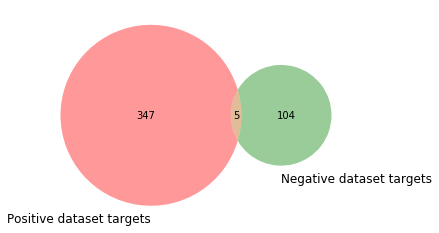

In [53]:
## Visualization of Positive repurposed drugs(removal of common taregts) v/s Negative repurposed drugs

data_merge_drug_pos1_target1=set(data_target_1['Drugbank_ids'])  
data_map_drug_neg1_target1=set(data_merge_uniq_neg) 
venn2([data_merge_drug_pos1_target1,data_map_drug_neg1_target1],['Positive dataset targets', 'Negative dataset targets'])
